# ***Prototype - Formula 1 Race Standings Prediction***

## **1. Introduction**

### 1.1. Context

This Jupyter Notebook is a prototype for my dissertation, focusing on the development of a system to predict Formula 1 race standings in real-time. The ultimate goal of the project is to build a robust and dynamic prediction model that utilises diverse data sources and integrates seamlessly into a user-friendly web application.

In this prototype, the emphasis is on implementing a basic Long Short-Term Memory (LSTM) model to predict the standings for the final race of the 2024 Formula 1 season. By working with sequential data from the 2024 season, this prototype establishes a foundation for processing and modelling Formula 1 data.


### 1.2. Objectives

- Develop a proof-of-concept LSTM model to predict race standings using sequential data.
- Evaluate the model’s performance on historical 2024 race data.
- Establish a baseline workflow for preprocessing and modelling Formula 1 race data.

### 1.3 Dataset

The dataset for this prototype includes comprehensive information about the 2024 Formula 1 season. It is organised into multiple structured files, each representing a key aspect of the races:

- **Circuit Data**: Information about race circuits, including locations and dates.  
- **Constructor Data**: Details about the teams participating in the season.  
- **Driver Data**: Profiles of the drivers, including their affiliations and attributes.  
- **Lap Data**: Lap-by-lap performance metrics for drivers.  
- **Pit stop Data**: Insights into pit stop events, including timing and duration.  
- **Qualifying Data**: Qualifying session results, such as positions and times.  
- **Race Results**: Final standings, points, and performance details for each race.

This data is fetched via the [Ergast Developer API](https://ergast.com/mrd/) and processed to create sequential time-series inputs for training the `LSTM` model.

### 1.4. Approach

The prototype follows a structured approach to develop and evaluate the prediction model:

1. **Data Fetching & Parsing**:  
   Data is fetched from the Ergast Developer API and organised into structured CSV files. This includes information about circuits, drivers, constructors, laps, pit stops, qualifying sessions, and race results.

2. **Data Pre-Processing**:  
   The data is cleaned, merged, and transformed into sequential time-series inputs suitable for training the Long Short-Term Memory (LSTM) model. Features are normalised, and missing values are handled appropriately.

3. **Model Building**:  
   An LSTM model is implemented using PyTorch to handle the time-series data. The model is designed to predict race standings based on sequential data from previous races.

4. **Training & Validation**:  
   The model is trained on historical data from the 2024 season, using a portion of the dataset for validation. Performance is evaluated using metrics such as Mean Squared Error (MSE).

5. **Prediction & Evaluation**:  
   The trained model is used to predict the standings for the final race of the 2024 season. Predictions are compared against actual results to assess the model's performance.

6. **Visualisation**:  
   Results and predictions are visualised to provide insights into the model's accuracy and areas for improvement.

### 1.5. Libraries & Constants

First, we import the necessary libraries and define constants that will be used throughout the prototype.

In [1]:
# General
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import pathlib
import requests
import time
from datetime import timedelta
from tabulate import tabulate

# ML
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from torch.utils.data import DataLoader, TensorDataset


# Constants
API_URL = "https://api.jolpi.ca/ergast/f1"

DATA_FOLDER = pathlib.Path("data")
BIN_FOLDER = DATA_FOLDER / "bin"
TRAIN_FOLDER = DATA_FOLDER / "meta"
TESTS_FOLDER = DATA_FOLDER / "tests"

OUT_FOLDER = pathlib.Path("out")
MODEL_PATH = OUT_FOLDER / "model.pth"


# Functions
def write_to_file(data: dict, filename: str) -> None:
    with open(filename, "w") as f:
        json.dump(data, f, indent=4)

def read_from_file(file_path: str) -> dict:
    with open(file_path, "r") as file:
        return json.load(file)


print("Project is Initialised!")

Project is Initialised!


## 2. **Fetching & Parsing Data**


### 2.1. Fetching Data

This section focuses on retrieving data for the 2024 Formula 1 season using the [Ergast Developer API](https://ergast.com/mrd/). Data is fetched programmatically and stored locally in a structured manner (`data/bin`) for subsequent preprocessing and analysis.

In [2]:
def fetch(session: requests.Session, *args, **kwargs) -> list:
    params = kwargs.pop('params', {})
    params['limit'] = 100
    params['offset'] = 0

    data = []
    while True:
        kwargs['params'] = params
        response = session.get(*args, **kwargs)
        if response.status_code == 200:
            result = response.json()

            if "RaceTable" in result['MRData']:
                data.extend(result['MRData']['RaceTable']['Races'])
            elif "DriverTable" in result['MRData']:
                data.extend(result['MRData']['DriverTable']['Drivers'])
            else:
                break

            total = int(result['MRData']['total'])
            params['offset'] += params['limit']
            if params['offset'] >= total:
                break
        elif response.status_code == 429:
            time.sleep(5)
        else:
            raise Exception(f"Failed to Fetch Data [{response.status_code}]: {response.text}")

    return data


def fetch_drivers(session: requests.Session) -> dict:
    data = fetch(session, f"{API_URL}/2024/drivers")
    return {'drivers': data}


def fetch_qualifying(session: requests.Session) -> dict:
    data = fetch(session, f"{API_URL}/2024/qualifying")
    return {'qualifying': data}


def fetch_results(session: requests.Session) -> dict:
    data = fetch(session, f"{API_URL}/2024/results")
    return {'results': data}


def fetch_laps(session: requests.Session, race: int) -> dict:
    data = fetch(session, f"{API_URL}/2024/{race}/laps")
    return {'laps': data}


def fetch_pitstops(session: requests.Session, race: int) -> dict:
    data = fetch(session, f"{API_URL}/2024/{race}/pitstops")
    return {'pitStops': data}


if not os.path.exists(BIN_FOLDER):
    print("Fetching Data . . .")
    os.makedirs(BIN_FOLDER)

    headers = {'Content-Type': 'application/json'}
    session = requests.Session()
    session.headers.update(headers)

    drivers = fetch_drivers(session)
    write_to_file(drivers, str(BIN_FOLDER / 'drivers.json'))
    print("- Fetched Driver Data")

    results = fetch_results(session)
    write_to_file(results, str(BIN_FOLDER / 'results.json'))
    print("- Fetched Results Data")

    qualifying = fetch_qualifying(session)
    write_to_file(qualifying, str(BIN_FOLDER / 'qualifying.json'))
    print("- Fetched Qualifying Data")

    data = {}
    for race in range(1, len(results['results'])):
        data[race] = {}

        laps = fetch_laps(session, race=race)
        data[race].update(laps)

        pitstops = fetch_pitstops(session, race=race)
        data[race].update(pitstops)

    write_to_file(data, str(BIN_FOLDER / 'laps_pitstops.json'))
    print("- Fetched Laps & Pitstops Data")
    print("Data Successfully Fetched!")
else:
    print("Data Already Fetched!")

Data Already Fetched!


### 2.2. Parsing Data

The raw data fetched via the API is processed and split into structured CSV files, stored in `data/train` and `data/tests` directories. This ensures compatibility with downstream processing and modelling tasks.

In [3]:
def _clean_status(status: str) -> str:
    if status.lower() == "finished":
        return "FINISHED"
    elif "+lap" in status.lower() or "+ laps" in status.lower():
        return "FINISHED"
    else:
        return "DNF"


def time_to_seconds(time_str: str) -> float:
    if pd.isna(time_str) or time_str == 0:
        return 0.0
    try:
        parts = time_str.split(":")
        if len(parts) == 2:
            minutes, seconds = parts
            return int(minutes) * 60 + float(seconds)
        elif len(parts) == 1:
            return float(parts[0])
        else:
            return 0.0
    except:
        return 0.0
    
    
def parse_qualifying(qualifying_data: dict) -> pd.DataFrame:
    qualifying_results = []
    for race in qualifying_data:
        season = race['season']
        round_number = race['round']
        for result in race['QualifyingResults']:
            qualifying_results.append({
                'season': season,
                'round': round_number,
                'car_number': result['number'],
                'position': result['position'],
                'driver_id': result['Driver']['driverId'],
                'constructor_id': result['Constructor']['constructorId'],
                'q1_time': result.get('Q1', None),
                'q2_time': result.get('Q2', None),
                'q3_time': result.get('Q3', None),
            })
    return pd.DataFrame(qualifying_results)


def parse_laps(laps_data: dict) -> pd.DataFrame:
    laps_records = []
    for race_id, race_details in laps_data.items():
        for details in race_details['laps']:
            for lap in details['Laps']:
                lap_number = lap['number']
                for timing in lap['Timings']:
                    laps_records.append({
                        'season': details['season'],
                        'round': details['round'],
                        'race_id': race_id,
                        'driver_id': timing['driverId'],
                        'lap_number': lap_number,
                        'position': timing['position'],
                        'time': timing['time']
                    })
    return pd.DataFrame(laps_records)


def parse_pitstops(pitstop_data: dict) -> pd.DataFrame:
    pitstop_records = []
    for race_id, race_details in pitstop_data.items():
        for details in race_details['pitStops']:
            for pitstop in details['PitStops']:
                pitstop_records.append({
                    'season': details['season'],
                    'round': details['round'],
                    'race_id': race_id,
                    'driver_id': pitstop['driverId'],
                    'stop_number': pitstop['stop'],
                    'lap_number': pitstop['lap'],
                    'time': pitstop['time'],
                    'duration': pitstop['duration']
                })
    return pd.DataFrame(pitstop_records)


def parse_results(results_df: pd.DataFrame) -> pd.DataFrame:
    results = []
    for _, row in results_df.iterrows():
        base_time = None
        for result in row['Results']:
            driver_data = {
                'season': row['season'],
                'round': row['round'],
                'car_number': result['number'],
                'position': result['position'],
                'points': result['points'],
                'driver_id': result['Driver']['driverId'],
                'constructor_id': result['Constructor']['constructorId'],
                'grid': result['grid'],
                'laps': result['laps'],
                'status': _clean_status(result['status']),
                'fastest_lap': result.get('FastestLap', {}).get('Time', {}).get('time', None),
            }

            time_str = result.get('Time', {}).get('time', None)
            if time_str:
                if time_str.startswith("+"):
                    if base_time:
                        base_parts = list(map(float, base_time.split(":")))
                        base_seconds = (
                            base_parts[0] * 3600 +
                            base_parts[1] * 60 + base_parts[2]
                            if len(base_parts) == 3 else
                            base_parts[0] * 60 + base_parts[1]
                            if len(base_parts) == 2 else
                            base_parts[0]
                        )

                        add_parts = time_str[1:].split(":")
                        add_seconds = float(add_parts[-1])
                        add_minutes = int(add_parts[0]) if len(add_parts) > 1 else 0
                        increment_seconds = add_minutes * 60 + add_seconds

                        total_seconds = base_seconds + increment_seconds
                        td = timedelta(seconds=total_seconds)
                        driver_data['time'] = f"{td.seconds // 3600}:{(td.seconds // 60) % 60}:{td.seconds % 60:06.3f}"
                    else:
                        driver_data['time'] = time_str
                else:
                    driver_data['time'] = time_str
                    base_time = time_str
            else:
                driver_data['time'] = None

            results.append(driver_data)

    df = pd.DataFrame(results)
    return df[['season', 'round', 'car_number', 'position', 'points', 'driver_id', 'constructor_id', 'grid', 'laps', 'status', 'time', 'fastest_lap']]


def parse_circuits(results_df: pd.DataFrame) -> pd.DataFrame:
    circuits = []
    for _, row in results_df.iterrows():
        circuit_data = {
            'season': row['season'],
            'round': row['round'],
            'url': row['url'],
            'race_name': row['raceName'],
            'circuit_id': row['Circuit.circuitId'],
            'circuit_url': row['Circuit.url'],
            'circuit_name': row['Circuit.circuitName'],
            'latitude': row['Circuit.Location.lat'],
            'longitude': row['Circuit.Location.long'],
            'locality': row['Circuit.Location.locality'],
            'country': row['Circuit.Location.country'],
            'date': row['date'],
            'time': row['time'],
        }
        circuits.append(circuit_data)
    return pd.DataFrame(circuits)


def parse_drivers(results_df: pd.DataFrame) -> pd.DataFrame:
    drivers = []
    for _, row in results_df.iterrows():
        for result in row['Results']:
            driver = result['Driver']
            drivers.append(
                {
                    'season': row['season'],
                    'driver_id': driver['driverId'],
                    'permanent_number': driver['permanentNumber'],
                    'code': driver['code'],
                    'url': driver['url'],
                    'given_name': driver['givenName'],
                    'family_name': driver['familyName'],
                    'date_of_birth': driver['dateOfBirth'],
                    'nationality': driver['nationality'],
                    'constructor_id': result['Constructor']['constructorId'],
                }
            )
    return pd.DataFrame(drivers).drop_duplicates(subset=['season', 'driver_id'])


def parse_constructors(results_df: pd.DataFrame) -> pd.DataFrame:
    constructors = []
    for _, row in results_df.iterrows():
        for result in row['Results']:
            constructor = result['Constructor']
            constructors.append(
                {
                    'constructor_id': constructor['constructorId'],
                    'url': constructor['url'],
                    'name': constructor['name'],
                    'nationality': constructor['nationality'],
                }
            )
    return pd.DataFrame(constructors).drop_duplicates(subset=['constructor_id'])

if not os.path.exists(TRAIN_FOLDER):
    print("Parsing Data . . .")
    os.makedirs(TRAIN_FOLDER)
    os.makedirs(TESTS_FOLDER)

    results_df = pd.json_normalize(
        read_from_file(str(BIN_FOLDER / 'results.json'))['results']
    )
    results_cleaned_df = parse_results(results_df)
    results_cleaned_df['round'] = pd.to_numeric(
        results_cleaned_df['round'], errors='coerce'
    )
    last_round = results_cleaned_df['round'].max()
    results_test_df = results_cleaned_df[results_cleaned_df['round'] == last_round]
    results_cleaned_df = results_cleaned_df[results_cleaned_df['round'] != last_round]
    results_test_df.to_csv(
        TESTS_FOLDER / 'results.csv',
        index=False, sep=';', encoding='UTF-8'
    )
    results_cleaned_df.to_csv(
        TRAIN_FOLDER / 'results.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    circuits_df = parse_circuits(results_df)
    circuits_df.to_csv(
        TRAIN_FOLDER / 'circuits.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    drivers_df = parse_drivers(results_df)
    drivers_df.to_csv(
        TRAIN_FOLDER / 'drivers.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    constructors_df = parse_constructors(results_df)
    constructors_df.to_csv(
        TRAIN_FOLDER / 'constructors.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    qualifying_df = parse_qualifying(
        read_from_file(str(BIN_FOLDER / 'qualifying.json'))['qualifying']
    )
    qualifying_df['round'] = pd.to_numeric(
        qualifying_df['round'], errors='coerce'
    )
    qualifying_df.to_csv(
        TRAIN_FOLDER / 'qualifying.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    laps_pitstops_data = read_from_file(str(BIN_FOLDER / 'laps_pitstops.json'))

    laps_df = parse_laps(laps_pitstops_data)
    laps_df['round'] = pd.to_numeric(laps_df['round'], errors='coerce')
    laps_df.to_csv(
        TRAIN_FOLDER / 'laps.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    pitstops_df = parse_pitstops(laps_pitstops_data)
    pitstops_df.to_csv(
        TRAIN_FOLDER / 'pitstops.csv',
        index=False, sep=';', encoding='UTF-8'
    )

    print("Data Successfully Parsed!")
else:
    print("Data Already Parsed!")

results_train_df = pd.read_csv(TRAIN_FOLDER / "results.csv", sep=";")
laps_train_df = pd.read_csv(TRAIN_FOLDER / "laps.csv", sep=";")
qualifying_train_df = pd.read_csv(TRAIN_FOLDER / "qualifying.csv", sep=";")
pitstops_train_df = pd.read_csv(TRAIN_FOLDER / "pitstops.csv", sep=";")
drivers_train_df = pd.read_csv(TRAIN_FOLDER / "drivers.csv", sep=";")
constructors_train_df = pd.read_csv(TRAIN_FOLDER / "constructors.csv", sep=";")
circuits_train_df = pd.read_csv(TRAIN_FOLDER / "circuits.csv", sep=";")

results_test_df = pd.read_csv(TESTS_FOLDER / "results.csv", sep=";")

Parsing Data . . .
Data Successfully Parsed!


### 2.3. Visualising Raw Data

To gain meaningful insights from the raw data, we visualise key metrics and trends. These visualisations help uncover patterns relevant to race outcomes and predictions.

- **Driver Performance Trends:**
  - Visualising the average qualifying position for each driver across the season reveals patterns in driver consistency and performance during qualifying sessions.

- **Race Results Trends:**
  - Analysing the average finishing position of drivers provides insights into overall race performance trends, highlighting the drivers who consistently finish in strong positions.

- **Pit Stop Efficiency:**
  - Comparing average pit stop durations between constructors reveals differences in operational efficiency, which can significantly impact race outcomes.

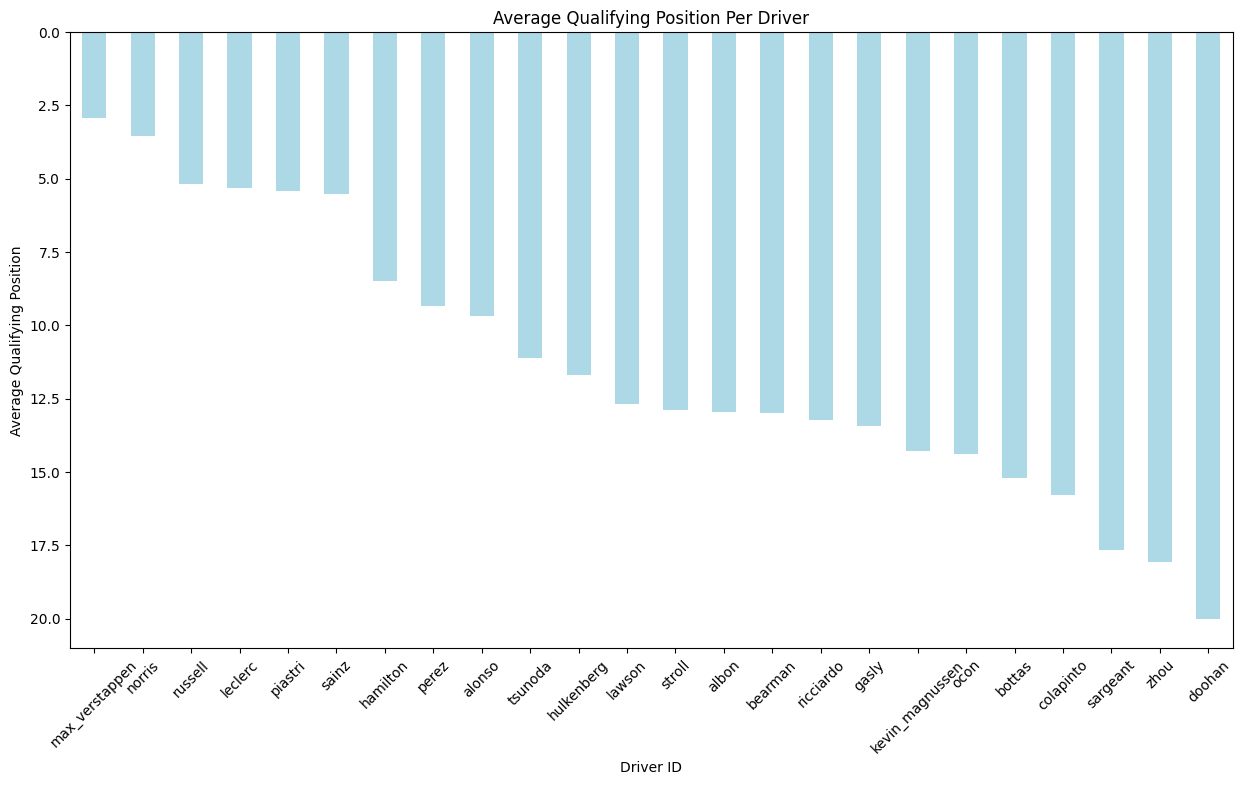

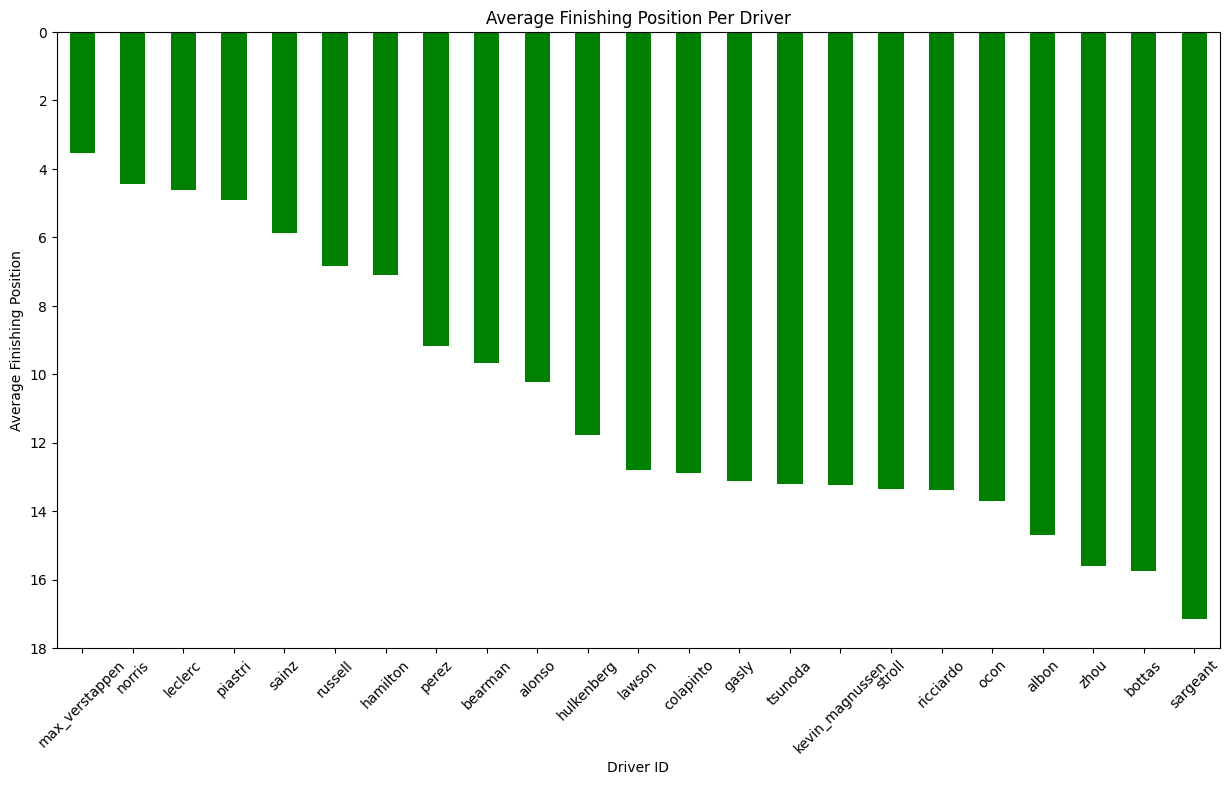

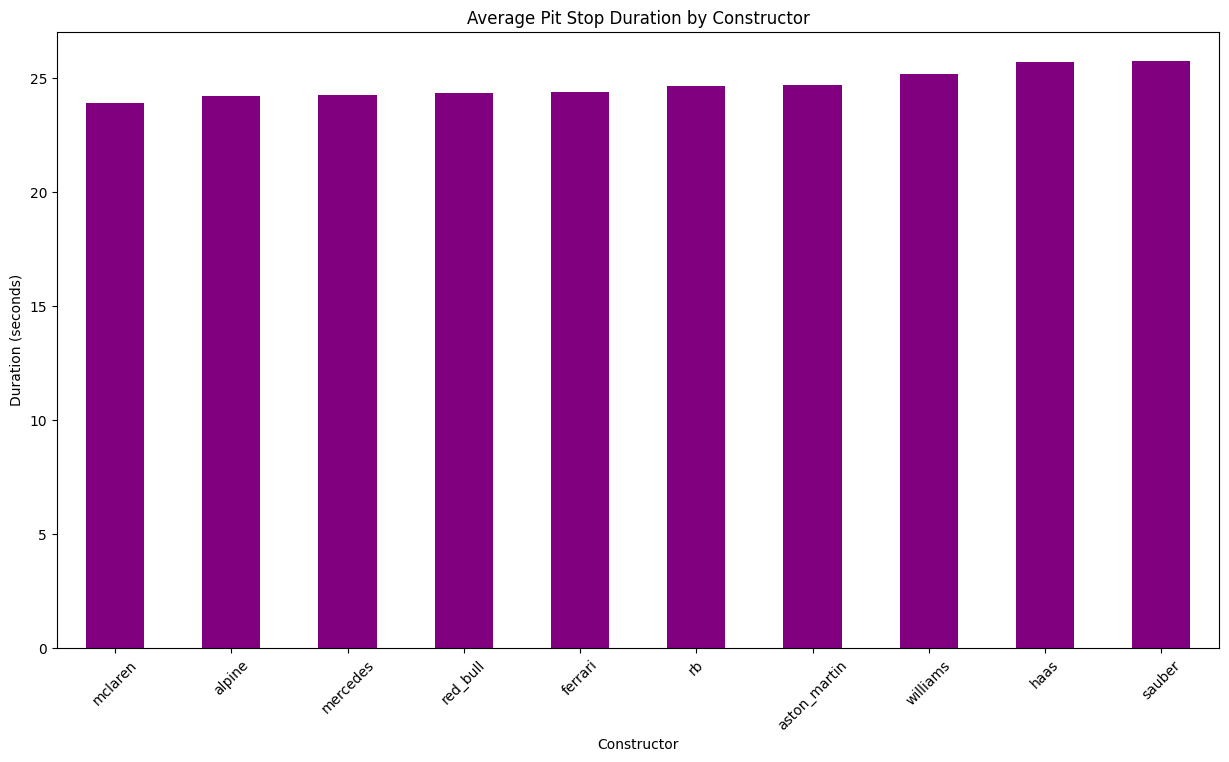

In [19]:
# Average Qualifying Position for Each Driver
avg_qualifying = qualifying_train_df.groupby("driver_id")["position"].mean().sort_values()
plt.figure(figsize=(15, 8))
avg_qualifying.plot(kind="bar", color="lightblue")
plt.title("Average Qualifying Position Per Driver")
plt.xlabel("Driver ID")
plt.ylabel("Average Qualifying Position")
plt.xticks(rotation=45)
plt.gca().invert_yaxis()
plt.show()

# Average Finishing Position for Each Driver
avg_finishing_position = results_train_df.groupby("driver_id")["position"].mean().sort_values()
plt.figure(figsize=(15, 8))
avg_finishing_position.plot(kind="bar", color="green")
plt.title("Average Finishing Position Per Driver")
plt.xlabel("Driver ID")
plt.ylabel("Average Finishing Position")
plt.xticks(rotation=45)
plt.gca().invert_yaxis() 
plt.show()

# Average Pit-Stop Duration for Each Constructor
pitstops_with_constructor = pitstops_train_df.merge(drivers_train_df, on="driver_id", how="left")
pitstops_with_constructor["duration"] = pd.to_numeric(pitstops_with_constructor["duration"], errors="coerce")
avg_pit_stop = pitstops_with_constructor.groupby("constructor_id")["duration"].mean().sort_values()
plt.figure(figsize=(15, 8))
avg_pit_stop.plot(kind="bar", color="purple")
plt.title("Average Pit Stop Duration by Constructor")
plt.xlabel("Constructor")
plt.ylabel("Duration (seconds)")
plt.xticks(rotation=45)
plt.show()

## 3. **Data Pre-Processing**


### 3.1. Cleaning & Merging Data

Data from the CSV files are combined to form a unified dataset in memory (`features`). Key steps include:
- Merging datasets based on common keys such as `season`, `round`, and `driver_id`.
- Retaining only relevant columns and renaming or dropping redundant ones.
- Handling inconsistencies and missing values in the merged dataset.

In [18]:
features = results_train_df.merge(qualifying_train_df, on=["season", "round", "driver_id"], how="left")
features = features.merge(laps_train_df, on=["season", "round", "driver_id"], how="left")
features = features.merge(pitstops_train_df, on=["season", "round", "driver_id"], how="left")

features.drop(columns=["lap_number_y"], inplace=True)
features.rename(columns={"lap_number_x": "lap_number"}, inplace=True)

table = tabulate(
    features.head(), 
    headers='keys', 
    tablefmt='pretty', 
    showindex=False
)
print(table)

+--------+-------+--------------+------------+--------+----------------+------------------+------+------+----------+-------------+-------------+--------------+------------+------------------+----------+----------+----------+-----------+------------+----------+----------+-----------+-------------+----------+----------+
| season | round | car_number_x | position_x | points |   driver_id    | constructor_id_x | grid | laps |  status  |   time_x    | fastest_lap | car_number_y | position_y | constructor_id_y | q1_time  | q2_time  | q3_time  | race_id_x | lap_number | position |  time_y  | race_id_y | stop_number |   time   | duration |
+--------+-------+--------------+------------+--------+----------------+------------------+------+------+----------+-------------+-------------+--------------+------------+------------------+----------+----------+----------+-----------+------------+----------+----------+-----------+-------------+----------+----------+
|  2024  |   1   |      1       |     1 

### 3.2. Normalising Numerical Features

Numerical features such as positions, points, grid positions, lap times, and durations are normalised to a range between 0 and 1. Time features are converted to seconds to maintain consistency.

In [17]:
for col in ['q1_time', 'q2_time', 'q3_time', 'duration']:
    if col in features.columns:
        features[col] = features[col].apply(time_to_seconds)

features.fillna(0, inplace=True)

numerical_columns = [
    'position', 'points', 'grid', 'laps', 'q1_time', 'q2_time',
    'q3_time', 'lap_number', 'duration'
]

scaler = MinMaxScaler()
features[numerical_columns] = scaler.fit_transform(features[numerical_columns])

table = tabulate(
    features.head(), 
    headers='keys', 
    tablefmt='pretty', 
    showindex=False
)
print(table)

+--------+-------+--------------+------------+--------+----------------+------------------+------+--------------------+----------+-------------+-------------+--------------+------------+------------------+--------------------+--------------------+--------------------+-----------+----------------------+----------+----------+-----------+-------------+----------+----------------------+
| season | round | car_number_x | position_x | points |   driver_id    | constructor_id_x | grid |        laps        |  status  |   time_x    | fastest_lap | car_number_y | position_y | constructor_id_y |      q1_time       |      q2_time       |      q3_time       | race_id_x |      lap_number      | position |  time_y  | race_id_y | stop_number |   time   |       duration       |
+--------+-------+--------------+------------+--------+----------------+------------------+------+--------------------+----------+-------------+-------------+--------------+------------+------------------+--------------------+--

### 3.3. Creating Time-Series Sequences

A sliding window approach is used to generate fixed-length sequences of data for each driver. Each sequence corresponds to a driver’s historical data across races, and the target is their position in the subsequent race.

In [7]:
sequence_length = 12

X, y = [], []
drivers = features['driver_id'].unique()

for driver in drivers:
    driver_data = features[features['driver_id'] == driver].sort_values(by=["round"])
    driver_data_seq = driver_data[numerical_columns].values

    if len(driver_data_seq) < sequence_length + 1:
        continue

    for i in range(len(driver_data_seq) - sequence_length):
        X.append(driver_data_seq[i:i + sequence_length])
        y.append(driver_data_seq[i + sequence_length][0])

X = torch.tensor(np.array(X), dtype=torch.float32)
y = torch.tensor(y, dtype=torch.float32)

print(X.shape, y.shape)

torch.Size([46025, 12, 9]) torch.Size([46025])


## 4. **Model Training & Validation**

### 4.1. Dataset Preparation

The training and validation datasets are created by splitting the preprocessed sequences (`X` and `y`) into training and validation sets. These datasets are then wrapped into PyTorch `DataLoader` objects for efficient batch processing.

In [8]:
os.makedirs(OUT_FOLDER, exist_ok=True)

X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

train_dataset = TensorDataset(X_train, y_train)
val_dataset = TensorDataset(X_val, y_val)

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)

print("Data Pre-Processing Complete!")

Data Pre-Processing Complete!


### 4.2. Model Definition

A Long Short-Term Memory (LSTM) model is defined using PyTorch. The model is designed to predict the driver’s position in the next race based on their previous performance across multiple races.

In [9]:
class F1_LSTM(nn.Module):
    def __init__(self, input_size: int, hidden_size: int, num_layers: int, output_size: int) -> None:
        super(F1_LSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        lstm_out, _ = self.lstm(x)
        last_out = lstm_out[:, -1, :]
        return self.fc(last_out)


input_size = len(numerical_columns)
hidden_size = 64
num_layers = 2
output_size = 1

model = F1_LSTM(input_size, hidden_size, num_layers, output_size)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

print(model)

F1_LSTM(
  (lstm): LSTM(9, 64, num_layers=2, batch_first=True)
  (fc): Linear(in_features=64, out_features=1, bias=True)
)


### 4.3. Model Training & Validation

The model is trained over multiple epochs. During each epoch:
- The model is fed batches of training data.
- The Mean Squared Error (MSE) loss is computed and minimised using backpropagation.
- Training progress and loss are logged.

The model’s performance is THEN validated on the validation dataset. The validation loss is calculated, and predictions are logged for comparison with actual values.

In [10]:
if os.path.exists(MODEL_PATH):
    print("Importing Model . . .")
    model.load_state_dict(torch.load(MODEL_PATH, weights_only=True))
    print("Model Successfully Imported!")
else:
    print("Training Model . . .")
    epochs = 25
    for epoch in range(epochs):
        model.train()
        epoch_loss = 0
        epoch_start = time.time()

        for batch_X, batch_y in train_loader:
            optimizer.zero_grad()
            outputs = model(batch_X)
            loss = criterion(outputs.squeeze(), batch_y)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        print(f"- Epoch {epoch + 1:02d}/{epochs} | Training Loss: {epoch_loss:.4f} | Time: {time.time() - epoch_start:.2f}s")

    torch.save(model.state_dict(), MODEL_PATH)
    print("Training Complete!")

model.eval()
val_loss = 0
predictions, actuals = [], []

with torch.no_grad():
    for batch_X, batch_y in val_loader:
        outputs = model(batch_X)
        loss = criterion(outputs.squeeze(), batch_y)
        val_loss += loss.item()

        predictions.extend(outputs.squeeze().tolist())
        actuals.extend(batch_y.tolist())

print(f"\nValidation Loss: {val_loss:.4f}")

Training Model . . .
- Epoch 01/25 | Training Loss: 9.9624 | Time: 3.27s
- Epoch 02/25 | Training Loss: 5.5843 | Time: 3.13s
- Epoch 03/25 | Training Loss: 5.5402 | Time: 3.13s
- Epoch 04/25 | Training Loss: 5.4751 | Time: 3.13s
- Epoch 05/25 | Training Loss: 5.5020 | Time: 3.16s
- Epoch 06/25 | Training Loss: 5.4232 | Time: 3.17s
- Epoch 07/25 | Training Loss: 5.4491 | Time: 3.14s
- Epoch 08/25 | Training Loss: 5.4367 | Time: 3.15s
- Epoch 09/25 | Training Loss: 5.3683 | Time: 3.15s
- Epoch 10/25 | Training Loss: 5.3984 | Time: 3.16s
- Epoch 11/25 | Training Loss: 5.3678 | Time: 3.17s
- Epoch 12/25 | Training Loss: 5.3218 | Time: 3.17s
- Epoch 13/25 | Training Loss: 5.3683 | Time: 3.18s
- Epoch 14/25 | Training Loss: 5.3475 | Time: 3.42s
- Epoch 15/25 | Training Loss: 5.3337 | Time: 3.21s
- Epoch 16/25 | Training Loss: 5.2962 | Time: 3.21s
- Epoch 17/25 | Training Loss: 5.3093 | Time: 3.22s
- Epoch 18/25 | Training Loss: 5.2969 | Time: 3.22s
- Epoch 19/25 | Training Loss: 5.2914 | Tim

## 5. **Prediction & Evaluation**

### 5.1. Preparing Test Data

The test data is processed in the same way as the training data. Key steps include:
- Merging `results`, `qualifying`, `laps`, `pitstops`, and `circuits` datasets for the test set.
- Normalising numerical features and converting time-based columns into seconds.
- Generating sequences for each driver based on their historical race data.

In [16]:
latest_round = qualifying_train_df['round'].max()
latest_qualifying_drivers = qualifying_train_df[qualifying_train_df['round'] == latest_round]['driver_id'].unique()

test_features = results_test_df.merge(qualifying_train_df, on=["season", "round", "driver_id"], how="left")
test_features = test_features.merge(laps_train_df, on=["season", "round", "driver_id"], how="left", suffixes=("", "_laps"))
test_features = test_features.merge(pitstops_train_df, on=["season", "round", "driver_id"], how="left", suffixes=("", "_pitstops"))
test_features = test_features.merge(circuits_train_df, on=["season", "round"], how="left")

test_features = test_features[test_features['driver_id'].isin(latest_qualifying_drivers)]
test_features.drop(columns=["lap_number_y"], inplace=True, errors="ignore")
test_features.rename(columns={"lap_number_x": "lap_number"}, inplace=True)

for col in ['q1_time', 'q2_time', 'q3_time', 'duration']:
    if col in test_features.columns:
        test_features[col] = test_features[col].apply(time_to_seconds)

test_features.fillna(0, inplace=True)

numerical_columns = [col for col in numerical_columns if col in test_features.columns]
test_features[numerical_columns] = scaler.transform(test_features[numerical_columns])

table = tabulate(
    features.head(), 
    headers='keys', 
    tablefmt='pretty', 
    showindex=False
)
print(table)

+--------+-------+--------------+------------+--------+----------------+------------------+------+------+----------+-------------+-------------+--------------+------------+------------------+----------+----------+----------+-----------+------------+----------+----------+-----------+-------------+----------+----------+
| season | round | car_number_x | position_x | points |   driver_id    | constructor_id_x | grid | laps |  status  |   time_x    | fastest_lap | car_number_y | position_y | constructor_id_y | q1_time  | q2_time  | q3_time  | race_id_x | lap_number | position |  time_y  | race_id_y | stop_number |   time   | duration |
+--------+-------+--------------+------------+--------+----------------+------------------+------+------+----------+-------------+-------------+--------------+------------+------------------+----------+----------+----------+-----------+------------+----------+----------+-----------+-------------+----------+----------+
|  2024  |   1   |      1       |     1 

### 5.2. Generating Predictions

The model is used to predict race standings for the final race of the 2024 season. Predictions are generated for each driver from the qualifying session, and these are compared against actual standings for evaluation.

In [12]:
test_X, test_y, tested_drivers = [], [], []
for driver in test_features['driver_id'].unique():
    driver_data = test_features[test_features['driver_id'] == driver].sort_values(by=["round"])
    driver_data_seq = driver_data[numerical_columns].values

    if len(driver_data_seq) < sequence_length + 1:
        padding = np.zeros((sequence_length - len(driver_data_seq), len(numerical_columns)))
        driver_data_seq = np.vstack((padding, driver_data_seq))

    test_X.append(driver_data_seq[-sequence_length:])
    test_y.append(driver_data.iloc[-1]['position_x'])
    tested_drivers.append(driver)

test_X = torch.tensor(np.array(test_X), dtype=torch.float32)
test_y = torch.tensor(test_y, dtype=torch.int32)

model.eval()
test_predictions = []

with torch.no_grad():
    outputs = model(test_X)
    test_predictions = outputs.squeeze().tolist()

min_position = results_train_df['position'].min()
max_position = results_train_df['position'].max()
test_predictions = [pred * (max_position - min_position) + min_position for pred in test_predictions]

print(test_X.shape, test_y.shape, len(tested_drivers), len(test_predictions))

torch.Size([20, 12, 9]) torch.Size([20]) 20 20


### 5.3. Displaying Results

The predictions are displayed alongside the actual standings in a tabulated format. This allows for easy comparison and assessment of the model’s performance.

In [13]:
race_name = test_features['race_name'].iloc[0]
season = test_features['season'].iloc[0]
round_number = test_features['round'].iloc[0]

display_data = []
for i, driver_id in enumerate(test_features['driver_id'].unique()):
    driver_info = drivers_train_df[drivers_train_df['driver_id'] == driver_id]
    driver_code = driver_info['code'].values[0] if not driver_info.empty else "N/A"
    driver_name = f"{driver_info['given_name'].values[0]} {driver_info['family_name'].values[0]}" if not driver_info.empty else "N/A"

    actual = int(test_y[i].item())
    predicted = round(test_predictions[i])

    display_data.append([driver_code, driver_name, actual, predicted])

header = f"{season} {race_name} (Round {round_number})"
table = tabulate(
    display_data,
    headers=["Driver Code", "Driver Name", "Actual Position", "Predicted Position"],
    tablefmt="fancy_grid",
    numalign="center",
    stralign="center"
)

print(header)
print(table)

2024 Abu Dhabi Grand Prix (Round 24)
╒═══════════════╤══════════════════╤═══════════════════╤══════════════════════╕
│  Driver Code  │   Driver Name    │  Actual Position  │  Predicted Position  │
╞═══════════════╪══════════════════╪═══════════════════╪══════════════════════╡
│      NOR      │   Lando Norris   │         1         │          2           │
├───────────────┼──────────────────┼───────────────────┼──────────────────────┤
│      SAI      │   Carlos Sainz   │         2         │          3           │
├───────────────┼──────────────────┼───────────────────┼──────────────────────┤
│      LEC      │ Charles Leclerc  │         3         │          5           │
├───────────────┼──────────────────┼───────────────────┼──────────────────────┤
│      HAM      │  Lewis Hamilton  │         4         │          6           │
├───────────────┼──────────────────┼───────────────────┼──────────────────────┤
│      RUS      │  George Russell  │         5         │          5           │
├──

## 6. **Conclusion**

### 6.1. Summary of Findings

This prototype successfully demonstrated the use of a Long Short-Term Memory (LSTM) model to predict Formula 1 race standings using sequential data from the 2024 season. Key findings include:
- **Model Performance**: The LSTM model exhibited reasonable predictive accuracy on the test dataset, effectively learning patterns from the training data. Validation losses indicated that the model generalised well, albeit with some limitations in precision for edge cases.

- **Data Integration**: Integrating multiple datasets, including laps, pitstops, qualifying, and race results, was critical for meaningful predictions. However, additional features like tyre strategies and weather data were identified as potential enhancements.

- **Insights for Real-Time Applications**: The prototype established a workflow for data fetching, preprocessing, and modelling, forming the backbone of future real-time prediction systems.

### 6.2. Limitations

While the prototype achieved its objectives, it faced several limitations:
- **Limited Dataset**: The model relied solely on the 2024 season's data, restricting its exposure to diverse race scenarios and historical patterns.

- **Feature Constraints**: Important real-time features, such as tyre data, weather conditions, and live telemetry, were not included, which could have improved prediction accuracy.

- **Simplistic Model Architecture**: The LSTM model used a basic configuration with minimal hyperparameter tuning, leaving room for architectural improvements.

- **Evaluation Scope**: Predictions were limited to the final race of the season, providing a narrow view of the model's capabilities across diverse race contexts.

### 6.3. Next Steps

Building on the insights from this prototype, the following steps are proposed to advance the project:
1. **Data Expansion**: Incorporate additional data sources such as tyre usage, weather conditions, and live race telemetry to enrich the feature set.

2. **Model Enhancement**: Experiment with advanced architectures, such as attention mechanisms or ensemble models, to improve accuracy and robustness.

3. **Real-Time Integration**: Utilise APIs for processing live data streams to enable real-time race predictions.

4. **Web-Application Development**: Build a front-end interface for visualising predictions, insights, and analysis in an intuitive and interactive format.
5. **Comprehensive Testing**: Evaluate the system across multiple seasons and scenarios to validate its reliability and scalability.

This prototype has laid a strong foundation for the development of a dynamic and real-time Formula 1 race prediction system. With further refinements, the project aims to deliver an indispensable tool for enthusiasts, analysts, and teams alike.